In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [55]:
dloc = Path("/Volumes/Glyph6TB/COOKIE")

MODEL = "MRI-CGCM3"#"IPSL-CM5A-LR"#"ECHAM-6_1_05" #"EC-EARTH"

In [56]:
ds1 = xr.open_mfdataset(dloc.glob(f"pr_day_{MODEL}_amip_*"))
pr1 = ds1['pr']

In [57]:
ds2 = xr.open_mfdataset(dloc.glob(f"pr_day_{MODEL}_offamip*"))
pr2 = ds2['pr']

In [58]:
# make sure that latitude is ordered monotonically increasing:
# (EC-EARTH)
if pr1['lat'][1] < pr1['lat'][0]:
    pr1 = pr1.reindex(lat=pr1.lat[::-1])
if pr2['lat'][1] < pr2['lat'][0]:
    pr2 = pr2.reindex(lat=pr2.lat[::-1])

In [59]:
pr1_trop = pr1.sel(lat=slice(-30, 30))
pr2_trop = pr2.sel(lat=slice(-30, 30))

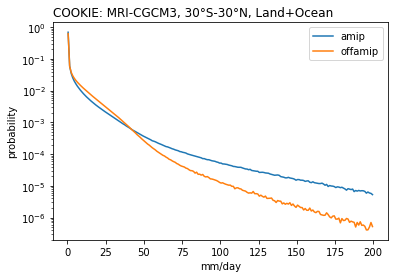

In [60]:
hist_bins = np.arange(0, 201, 1)
bin_center = hist_bins[0:-1] + np.diff(hist_bins)/2
weights = np.cos(np.radians(pr1_trop['lat'])).broadcast_like(pr1_trop)
ahist, _ = np.histogram(pr1_trop.values.flatten()*86400, bins=hist_bins, weights=weights.values.flatten(), density=True)
ahist = xr.DataArray(ahist, dims=["bins"], coords={"bins":bin_center}, name='pr', attrs=pr1_trop.attrs)
ahist.attrs['long_name'] = f"pr area-weighted histogram (in density) for ocean points in latitude band"
ahist.attrs['units'] = "mm d^-1"

weights = np.cos(np.radians(pr2_trop['lat'])).broadcast_like(pr2_trop)
bhist, _ = np.histogram(pr2_trop.values.flatten()*86400, bins=hist_bins, weights=weights.values.flatten(), density=True)
bhist = xr.DataArray(bhist, dims=["bins"], coords={"bins":bin_center}, name='pr', attrs=pr2_trop.attrs)
bhist.attrs['long_name'] = f"pr area-weighted histogram (in density) for ocean points in latitude band"
bhist.attrs['units'] = "mm d^-1"

fig, ax = plt.subplots()
ax.plot(bin_center, ahist, label='amip')
ax.plot(bin_center, bhist, label='offamip')
ax.semilogy()
ax.set_title(f"COOKIE: {MODEL}, 30\u00B0S-30\u00B0N, Land+Ocean", loc='left')
ax.legend()
ax.set_xlabel("mm/day")
ax.set_ylabel("probability")
fig.savefig(f"/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/cookie_{MODEL}_histogram_landocean.pdf")

In [61]:
# degree: print("\u00B0")

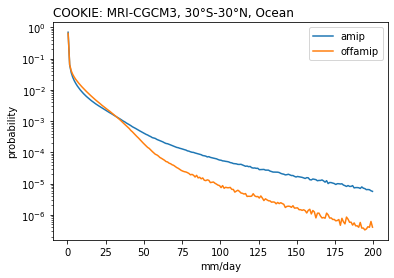

In [62]:
land_fil = dloc / f'sftlf_fx_{MODEL}_amip_r0i0p0.nc'
if land_fil.is_file():
    land_ds = xr.open_dataset(land_fil)
    land = land_ds['sftlf']
    amask, _ = xr.broadcast(land.sel(lat=slice(-30,30)), pr1_trop)
    adata = pr1_trop.where(amask <= 0)
    bmask, _ = xr.broadcast(land.sel(lat=slice(-30,30)), pr2_trop)
    bdata = pr2_trop.where(bmask <= 0)

    weights = np.cos(np.radians(pr1_trop['lat'])).broadcast_like(pr1_trop)
    ahist2, _ = np.histogram(adata.values.flatten()*86400, bins=hist_bins, weights=weights.values.flatten(), density=True)
    ahist2 = xr.DataArray(ahist2, dims=["bins"], coords={"bins":bin_center}, name='pr', attrs=pr1_trop.attrs)
    ahist2.attrs['long_name'] = f"pr area-weighted histogram (in density) for ocean points in latitude band"
    ahist2.attrs['units'] = "mm d^-1"

    weights = np.cos(np.radians(pr2_trop['lat'])).broadcast_like(pr2_trop)
    bhist2, _ = np.histogram(bdata.values.flatten()*86400, bins=hist_bins, weights=weights.values.flatten(), density=True)
    bhist2 = xr.DataArray(bhist2, dims=["bins"], coords={"bins":bin_center}, name='pr', attrs=pr2_trop.attrs)
    bhist2.attrs['long_name'] = f"pr area-weighted histogram (in density) for ocean points in latitude band"
    bhist2.attrs['units'] = "mm d^-1"

    fig, ax = plt.subplots()
    ax.plot(bin_center, ahist2, label='amip')
    ax.plot(bin_center, bhist2, label='offamip')
    ax.semilogy()
    ax.set_title(f"COOKIE: {MODEL}, 30\u00B0S-30\u00B0N, Ocean", loc='left')
    ax.legend()
    ax.set_xlabel("mm/day")
    ax.set_ylabel("probability")
    fig.savefig(f"/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/cookie_{MODEL}_histogram_ocean.pdf")
else:
    print("No land file available.")